In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt 
from matplotlib.patches import Rectangle
from IPython.display import Image, display
import pandas as pd
from salishsea_tools import viz_tools, places, visualisations

### Functions

In [2]:
variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens','init_lat']

#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age','final_dens','init_dens','init_lat']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = xr.DataArray(age)
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var      

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
date = dt.datetime(2018,1,1)
enddate = dt.datetime(2018,12,31)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)

In [5]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forvs_all','forpr_all','foradm_all','forgulf_all']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5]
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t65/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i
    
dict_sectiontransp = {}

for file in files:
    st_dict = {}
    for section in sectionnum:
        if section not in st_dict:
            st_dict[section] = []
            
        for date in dates:
            try:
                st_dict[section].append(get_datat(dicts[file][date],section,starttime,endtime))
            except:
                print(date)
                pass 
        dict_sectiontransp[file] = st_dict


28may18
28may18
28may18
28may18
28may18
28may18


In [6]:
datelist_pr = datelist_vs.copy()
datelist_pr.pop(58)

#forvs
vstopr = pd.DataFrame({'Transport':dict_sectiontransp['forvs_all'][4]},index=datelist_vs)
vstoadm = pd.DataFrame({'Transport':dict_sectiontransp['forvs_all'][2]},index=datelist_vs)
vstogulf = pd.DataFrame({'Transport':dict_sectiontransp['forvs_all'][5]},index=datelist_vs)

#forpr
prtovs = pd.DataFrame({'Transport':dict_sectiontransp['forpr_all'][4]},index=datelist_pr)
prtoadm = pd.DataFrame({'Transport':dict_sectiontransp['forpr_all'][2]},index=datelist_pr)
prtogulf = pd.DataFrame({'Transport':dict_sectiontransp['forpr_all'][5]},index=datelist_pr)

#forgulf
gulftopr = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_all'][4]},index=datelist_vs)
gulftoadm = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_all'][2]},index=datelist_vs)
gulftovs = pd.DataFrame({'Transport':dict_sectiontransp['forgulf_all'][5]},index=datelist_vs)

#foradm
admtopr = pd.DataFrame({'Transport':dict_sectiontransp['foradm_all'][4]},index=datelist_vs)
admtovs = pd.DataFrame({'Transport':dict_sectiontransp['foradm_all'][2]},index=datelist_vs)
admtogulf = pd.DataFrame({'Transport':dict_sectiontransp['foradm_all'][5]},index=datelist_vs)

In [7]:
#forvs
vstopr = vstopr.resample('M').mean()
vstoadm = vstoadm.resample('M').mean()
vstogulf = vstogulf.resample('M').mean()

#foradm
admtopr = admtopr.resample('M').mean()
admtovs = admtovs.resample('M').mean()
admtogulf = admtogulf.resample('M').mean()

#forgulf
gulftopr = gulftopr.resample('M').mean()
gulftoadm = gulftoadm.resample('M').mean()
gulftovs = gulftovs.resample('M').mean()

#forpr
prtogulf = prtogulf.resample('M').mean()
prtoadm = prtoadm.resample('M').mean()
prtovs = prtovs.resample('M').mean()

## Balances

In [8]:
leave_vic = np.zeros_like(vstoadm)
ent_vic = np.zeros_like(vstoadm)
leave_adm = np.zeros_like(vstoadm)
ent_adm = np.zeros_like(vstoadm)
leave_gulf = np.zeros_like(vstoadm)
ent_gulf = np.zeros_like(vstoadm)
leave_pr = np.zeros_like(vstoadm)
ent_pr = np.zeros_like(vstoadm)
leave_total = np.zeros_like(vstoadm)
ent_total = np.zeros_like(vstoadm)

for i in range(12):
    leave_vic[i] = np.sum([vstoadm.Transport[i],vstogulf.Transport[i],vstopr.Transport[i]])
    ent_vic[i] = np.sum([prtovs.Transport[i],admtovs.Transport[i],gulftovs.Transport[i]])

    leave_adm[i] = np.sum([admtovs.Transport[i],admtopr.Transport[i],admtogulf.Transport[i]])
    # leave_adm[i] = np.sum([np.mean([admtovs_sjc_avg.Transport[i] ,admtovs_ros_avg.Transport[i] ]),admtopr_ros_avg.Transport[i],admtogulf_ros_avg.Transport[i],admtopr_haro_avg.Transport[i],admtogulf_haro_avg.Transport[i],admtopr_sjc_avg.Transport[i],admtogulf_sjc_avg.Transport[i]])
    ent_adm[i] = np.sum([vstoadm.Transport[i],gulftoadm.Transport[i],prtoadm.Transport[i]])
    
    leave_pr[i] = np.sum([prtoadm.Transport[i],prtovs.Transport[i],prtogulf.Transport[i]])
    ent_pr[i] = np.sum([vstopr.Transport[i],gulftopr.Transport[i],admtopr.Transport[i]])
    
    leave_gulf[i] = np.sum([gulftovs.Transport[i],gulftopr.Transport[i],gulftoadm.Transport[i]])
    ent_gulf[i] = np.sum([admtogulf.Transport[i],vstogulf.Transport[i],prtogulf.Transport[i]])

    leave_total[i] = np.sum([leave_vic[i],leave_pr[i],leave_adm[i],leave_gulf[i]])
    ent_total[i] = np.sum([ent_vic[i],ent_pr[i],ent_adm[i],ent_gulf[i]])

### Plotting 

/tmp/ipykernel_2783529/679966944.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(135, 288, '{:.1f}'.format(float(np.round(leave_vic[ii] / 1000, 1))),color='navy')
/tmp/ipykernel_2783529/679966944.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(135, 265, '{:.1f}'.format(float(np.round(ent_vic[ii] / 1000, 1))),color='blue')
/tmp/ipykernel_2783529/679966944.py:41: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(267, 415, '{:.1f}'.format

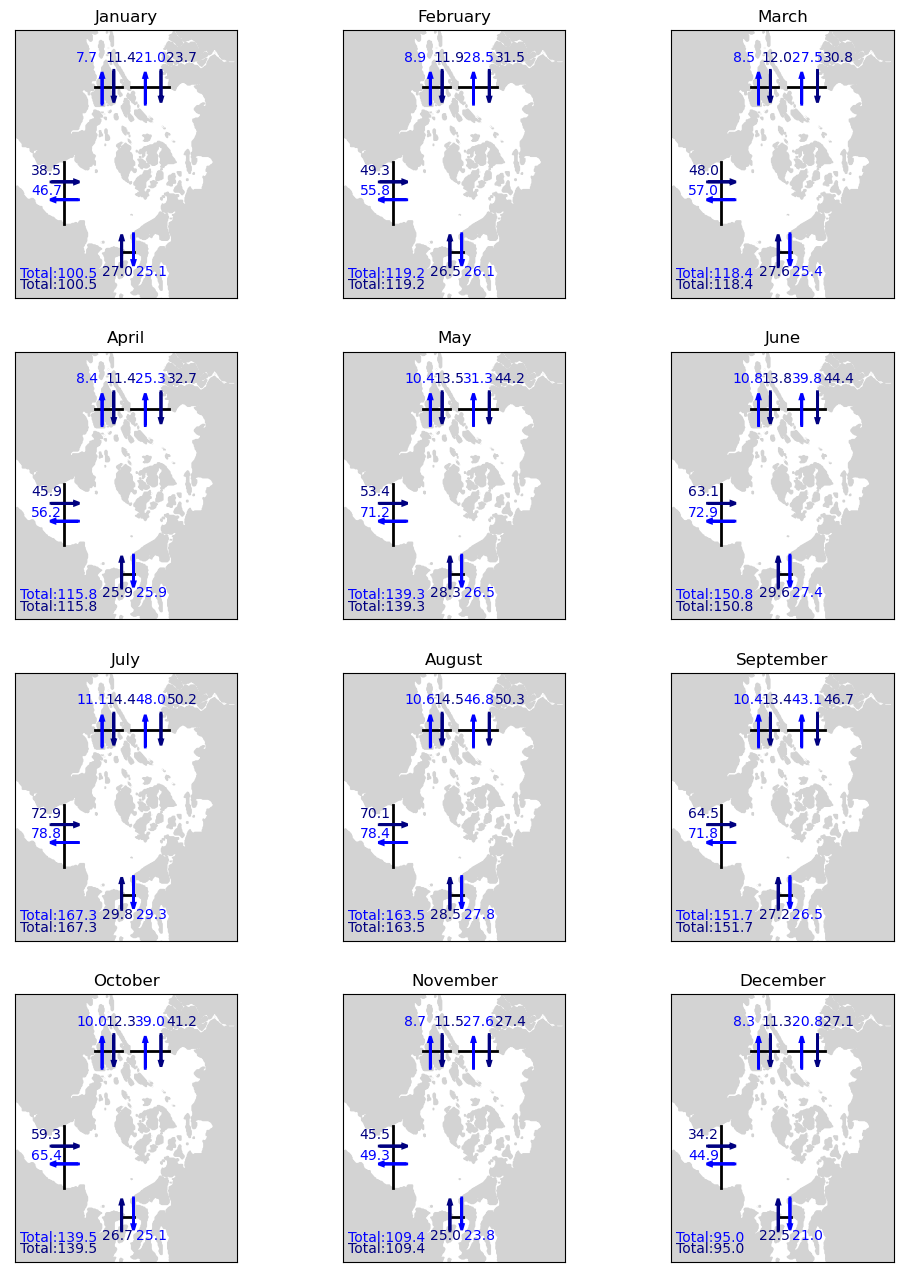

In [9]:
vs_y = np.arange(233,303,1)
vs_x = np.linspace(177,177,len(vs_y))
adm_x = np.arange(252,267,1)
adm_y = np.linspace(201,201,len(adm_x))
pr_x = np.arange(262,311,1)
pr_y = np.linspace(386,386,len(pr_x))
gulf_x = np.arange(216,251,1)
gulf_y = np.linspace(386,386,len(gulf_x))

months = ['January','February','March','April','May','June','July','August','September','October','November','December']
lw = 2

subdomain = [114, 397, 150, 450]
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12]] = plt.subplots(4,3,figsize=(12, 16))

# for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
    for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
        getattr(ax, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

    ax.set_xlim(subdomain[:2])
    ax.set_ylim(subdomain[2:])
    # ax.set_xlabel('Grid X')
    # ax.set_ylabel('Grid Y')
    ax.set_xticks([])
    ax.set_yticks([])
    viz_tools.set_aspect(ax);

    ax.plot(vs_x,vs_y,color='k',lw=2)
    ax.plot(adm_x,adm_y,color='k',lw=2)
    ax.plot(pr_x,pr_y,color='k',lw=2)
    ax.plot(gulf_x,gulf_y,color='k',lw=2)

    #VicSill arrows
    ax.text(135, 288, '{:.1f}'.format(float(np.round(leave_vic[ii] / 1000, 1))),color='navy')
    ax.text(135, 265, '{:.1f}'.format(float(np.round(ent_vic[ii] / 1000, 1))),color='blue')
    ax.arrow(160, 280, 30, 0, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(195, 260, -30, 0, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    #PointRob arrows
    ax.text(267, 415, '{:.1f}'.format(float(np.round(ent_pr[ii] / 1000, 1))),color='blue')
    ax.text(307, 415, '{:.1f}'.format(float(np.round(leave_pr[ii] / 1000, 1))),color='navy')
    ax.arrow(280, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    ax.arrow(300, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

    #Gulf arrows
    ax.text(192, 415, '{:.1f}'.format(float(np.round(ent_gulf[ii] / 1000, 1))),color='blue')
    ax.text(229, 415, '{:.1f}'.format(float(np.round(leave_gulf[ii] / 1000, 1))),color='navy')
    ax.arrow(225, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    ax.arrow(240, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

    #Adm arrows
    ax.text(225, 175, '{:.1f}'.format(float(np.round(leave_adm[ii] / 1000, 1))),color='navy')
    ax.text(268, 175, '{:.1f}'.format(float(np.round(ent_adm[ii] / 1000, 1))),color='blue')
    ax.arrow(250, 185, 0, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(265, 222, 0, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    
    #Total
    ax.text(120, 160, 'Total:'+ '{:.1f}'.format(float(np.round(ent_total[ii] / 1000, 1))),color='navy')
    ax.text(120, 173, 'Total:'+ '{:.1f}'.format(float(np.round(leave_total[ii] / 1000, 1))),color='blue')
    
    ax.set_title(months[ii])

# fig.subplots_adjust(hspace=0.08,wspace=-0.35)

### Through files

In [10]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_sjc3','forgulf_sjc3','forvs_sjc3','foradm_sjc3','forpr_ros3','forgulf_ros3','forvs_ros3','foradm_ros3',
         'forpr_haro3','forgulf_haro3','forvs_haro3','foradm_haro32'] # Update config for foradm_haro
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]
     
dicts_thru = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts_thru[file] = dict_i
    
thru_sectiontransp = {}

for file in files:
    st_dict = {}
    for section in sectionnum:
        if section not in st_dict:
            st_dict[section] = []
            
        for date in dates:
            try:
                st_dict[section].append(get_datat(dicts_thru[file][date],section,starttime,endtime))
            except:
                print(date)
                pass 
        thru_sectiontransp[file] = st_dict


28may18
28may18
28may18
28may18
28may18
28may18
28may18
28may18
28may18


In [11]:
#forpr_sjc
prtovs_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forpr_sjc3'][5]},index=datelist_pr)
prtoadm_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forpr_sjc3'][2]},index=datelist_pr)
prtogulf_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forpr_sjc3'][7]},index=datelist_pr)

#forpr_haro
prtovs_haro = pd.DataFrame({'Transport':thru_sectiontransp['forpr_haro3'][6]},index=datelist_vs)
prtoadm_haro = pd.DataFrame({'Transport':thru_sectiontransp['forpr_haro3'][2]},index=datelist_vs)
prtogulf_haro = pd.DataFrame({'Transport':thru_sectiontransp['forpr_haro3'][7]},index=datelist_vs)

#forpr_ros
prtovs_ros = pd.DataFrame({'Transport':thru_sectiontransp['forpr_ros3'][4]},index=datelist_vs)
prtoadm_ros = pd.DataFrame({'Transport':thru_sectiontransp['forpr_ros3'][2]},index=datelist_vs)
prtogulf_ros = pd.DataFrame({'Transport':thru_sectiontransp['forpr_ros3'][7]},index=datelist_vs)

#forgulf_haro
gulftovs_haro = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_haro3'][7]},index=datelist_vs)
gulftoadm_haro = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_haro3'][2]},index=datelist_vs)
gulftopr_haro = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_haro3'][6]},index=datelist_vs)

#forgulf_ros
gulftovs_ros = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_ros3'][7]},index=datelist_vs)
gulftoadm_ros = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_ros3'][2]},index=datelist_vs)
gulftopr_ros = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_ros3'][4]},index=datelist_vs)

#forgulf_sjc
gulftovs_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_sjc3'][7]},index=datelist_vs)
gulftoadm_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_sjc3'][2]},index=datelist_vs)
gulftopr_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forgulf_sjc3'][5]},index=datelist_vs)

#forvs_haro
vstogulf_haro = pd.DataFrame({'Transport':thru_sectiontransp['forvs_haro3'][7]},index=datelist_vs)
vstoadm_haro = pd.DataFrame({'Transport':thru_sectiontransp['forvs_haro3'][2]},index=datelist_vs)
vstopr_haro = pd.DataFrame({'Transport':thru_sectiontransp['forvs_haro3'][6]},index=datelist_vs)

#forvs_ros
vstogulf_ros = pd.DataFrame({'Transport':thru_sectiontransp['forvs_ros3'][7]},index=datelist_vs)
vstoadm_ros = pd.DataFrame({'Transport':thru_sectiontransp['forvs_ros3'][2]},index=datelist_vs)
vstopr_ros = pd.DataFrame({'Transport':thru_sectiontransp['forvs_ros3'][4]},index=datelist_vs)

#forvs_sjc
vstogulf_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forvs_sjc3'][7]},index=datelist_vs)
vstoadm_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forvs_sjc3'][2]},index=datelist_vs)
vstopr_sjc = pd.DataFrame({'Transport':thru_sectiontransp['forvs_sjc3'][5]},index=datelist_vs)

#foradm_haro
admtogulf_haro = pd.DataFrame({'Transport':thru_sectiontransp['foradm_haro32'][7]},index=datelist_vs)
admtovs_haro = pd.DataFrame({'Transport':thru_sectiontransp['foradm_haro32'][2]},index=datelist_vs)
admtopr_haro = pd.DataFrame({'Transport':thru_sectiontransp['foradm_haro32'][6]},index=datelist_vs)

#foradm_ros
admtogulf_ros = pd.DataFrame({'Transport':thru_sectiontransp['foradm_ros3'][7]},index=datelist_vs)
admtovs_ros = pd.DataFrame({'Transport':thru_sectiontransp['foradm_ros3'][2]},index=datelist_vs)
admtopr_ros = pd.DataFrame({'Transport':thru_sectiontransp['foradm_ros3'][4]},index=datelist_vs)

#foradm_sjc
admtogulf_sjc = pd.DataFrame({'Transport':thru_sectiontransp['foradm_sjc3'][7]},index=datelist_vs)
admtovs_sjc = pd.DataFrame({'Transport':thru_sectiontransp['foradm_sjc3'][2]},index=datelist_vs)
admtopr_sjc = pd.DataFrame({'Transport':thru_sectiontransp['foradm_sjc3'][5]},index=datelist_vs)

#foradm
admtopr_sjc_avg_NS = admtopr_sjc.resample('M').mean()
admtovs_sjc_avg_NS = admtovs_sjc.resample('M').mean()
admtogulf_sjc_avg_NS = admtogulf_sjc.resample('M').mean()

admtopr_ros_avg_NS = admtopr_ros.resample('M').mean()
admtovs_ros_avg_NS = admtovs_ros.resample('M').mean()
admtogulf_ros_avg_NS = admtogulf_ros.resample('M').mean()

admtopr_haro_avg_NS = admtopr_haro.resample('M').mean()
admtovs_haro_avg_NS = admtovs_haro.resample('M').mean()
admtogulf_haro_avg_NS = admtogulf_haro.resample('M').mean()

#forvs
vstopr_sjc_avg_NS = vstopr_sjc.resample('M').mean()
vstoadm_sjc_avg_NS = vstoadm_sjc.resample('M').mean()
vstogulf_sjc_avg_NS = vstogulf_sjc.resample('M').mean()

vstopr_haro_avg_NS = vstopr_haro.resample('M').mean()
vstoadm_haro_avg_NS = vstoadm_haro.resample('M').mean()
vstogulf_haro_avg_NS = vstogulf_haro.resample('M').mean()

vstopr_ros_avg_NS = vstopr_ros.resample('M').mean()
vstoadm_ros_avg_NS = vstoadm_ros.resample('M').mean()
vstogulf_ros_avg_NS = vstogulf_ros.resample('M').mean()

#forgulf
gulftopr_sjc_avg_NS = gulftopr_sjc.resample('M').mean()
gulftoadm_sjc_avg_NS = gulftoadm_sjc.resample('M').mean()
gulftovs_sjc_avg_NS = gulftovs_sjc.resample('M').mean()

gulftopr_haro_avg_NS = gulftopr_haro.resample('M').mean()
gulftoadm_haro_avg_NS = gulftoadm_haro.resample('M').mean()
gulftovs_haro_avg_NS = gulftovs_haro.resample('M').mean()

gulftopr_ros_avg_NS = gulftopr_ros.resample('M').mean()
gulftoadm_ros_avg_NS = gulftoadm_ros.resample('M').mean()
gulftovs_ros_avg_NS = gulftovs_ros.resample('M').mean()

#forpr
prtogulf_sjc_avg_NS = prtogulf_sjc.resample('M').mean()
prtoadm_sjc_avg_NS = prtoadm_sjc.resample('M').mean()
prtovs_sjc_avg_NS = prtovs_sjc.resample('M').mean()

prtogulf_haro_avg_NS = prtogulf_haro.resample('M').mean()
prtoadm_haro_avg_NS = prtoadm_haro.resample('M').mean()
prtovs_haro_avg_NS = prtovs_haro.resample('M').mean()

prtogulf_ros_avg_NS = prtogulf_ros.resample('M').mean()
prtoadm_ros_avg_NS = prtoadm_ros.resample('M').mean()
prtovs_ros_avg_NS = prtovs_ros.resample('M').mean()

In [12]:
leave_vic_thru = np.zeros_like(vstoadm_haro_avg_NS)
ent_vic_thru = np.zeros_like(vstoadm_haro_avg_NS)
leave_adm_thru = np.zeros_like(vstoadm_haro_avg_NS)
ent_adm_thru = np.zeros_like(vstoadm_haro_avg_NS)
leave_gulf_thru = np.zeros_like(vstoadm_haro_avg_NS)
ent_gulf_thru = np.zeros_like(vstoadm_haro_avg_NS)
leave_pr_thru = np.zeros_like(vstoadm_haro_avg_NS)
ent_pr_thru = np.zeros_like(vstoadm_haro_avg_NS)
leave_total_thru = np.zeros_like(vstoadm_haro_avg_NS)
ent_total_thru = np.zeros_like(vstoadm_haro_avg_NS)

for i in range(12):
    leave_vic_thru[i] = np.sum([vstoadm_haro_avg_NS.Transport[i],vstopr_ros_avg_NS.Transport[i],vstogulf_ros_avg_NS.Transport[i],vstopr_haro_avg_NS.Transport[i],vstogulf_haro_avg_NS.Transport[i],vstopr_sjc_avg_NS.Transport[i],vstogulf_sjc_avg_NS.Transport[i]])
    ent_vic_thru[i] = np.sum([admtovs_haro_avg_NS.Transport[i],prtovs_ros_avg_NS.Transport[i],gulftovs_ros_avg_NS.Transport[i],prtovs_haro_avg_NS.Transport[i],gulftovs_haro_avg_NS.Transport[i],prtovs_sjc_avg_NS.Transport[i],gulftovs_sjc_avg_NS.Transport[i]])

    leave_adm_thru[i] = np.sum([admtovs_haro_avg_NS.Transport[i],admtopr_ros_avg_NS.Transport[i],admtogulf_ros_avg_NS.Transport[i],admtopr_haro_avg_NS.Transport[i],admtogulf_haro_avg_NS.Transport[i],admtopr_sjc_avg_NS.Transport[i],admtogulf_sjc_avg_NS.Transport[i]])
    # leave_adm[i] = np.sum([np.mean([admtovs_sjc_avg.Transport[i] ,admtovs_ros_avg.Transport[i] ]),admtopr_ros_avg.Transport[i],admtogulf_ros_avg.Transport[i],admtopr_haro_avg.Transport[i],admtogulf_haro_avg.Transport[i],admtopr_sjc_avg.Transport[i],admtogulf_sjc_avg.Transport[i]])
    ent_adm_thru[i] = np.sum([vstoadm_haro_avg_NS.Transport[i],prtoadm_ros_avg_NS.Transport[i],gulftoadm_ros_avg_NS.Transport[i],prtoadm_haro_avg_NS.Transport[i],gulftoadm_haro_avg_NS.Transport[i],prtoadm_sjc_avg_NS.Transport[i],gulftoadm_sjc_avg_NS.Transport[i]])
    
    leave_pr_thru[i] = np.sum([prtogulf_haro_avg_NS.Transport[i],prtoadm_ros_avg_NS.Transport[i],prtovs_ros_avg_NS.Transport[i],prtoadm_haro_avg_NS.Transport[i],prtovs_haro_avg_NS.Transport[i],prtoadm_sjc_avg_NS.Transport[i],prtovs_sjc_avg_NS.Transport[i]])
    ent_pr_thru[i] = np.sum([gulftopr_haro_avg_NS.Transport[i],admtopr_ros_avg_NS.Transport[i],vstopr_ros_avg_NS.Transport[i],admtopr_haro_avg_NS.Transport[i],vstopr_haro_avg_NS.Transport[i],admtopr_sjc_avg_NS.Transport[i],vstopr_sjc_avg_NS.Transport[i]])
    
    leave_gulf_thru[i] = np.sum([gulftopr_haro_avg_NS.Transport[i],gulftoadm_ros_avg_NS.Transport[i],gulftovs_ros_avg_NS.Transport[i],gulftoadm_haro_avg_NS.Transport[i],gulftovs_haro_avg_NS.Transport[i],gulftoadm_sjc_avg_NS.Transport[i],gulftovs_sjc_avg_NS.Transport[i]])
    ent_gulf_thru[i] = np.sum([prtogulf_haro_avg_NS.Transport[i],admtogulf_ros_avg_NS.Transport[i],vstogulf_ros_avg_NS.Transport[i],admtogulf_haro_avg_NS.Transport[i],vstogulf_haro_avg_NS.Transport[i],admtogulf_sjc_avg_NS.Transport[i],vstogulf_sjc_avg_NS.Transport[i]])

    leave_total_thru[i] = np.sum([leave_vic_thru[i],leave_pr_thru[i],leave_adm_thru[i],leave_gulf_thru[i]])
    ent_total_thru[i] = np.sum([ent_vic_thru[i],ent_pr_thru[i],ent_adm_thru[i],ent_gulf_thru[i]])

In [13]:
N_haro = np.sum([vstopr_haro_avg_NS,vstogulf_haro_avg_NS,admtogulf_haro_avg_NS,admtopr_haro_avg_NS],axis=0)
N_ros = np.sum([vstopr_ros_avg_NS,vstogulf_ros_avg_NS,admtogulf_ros_avg_NS,admtopr_ros_avg_NS],axis=0)
N_sjc = np.sum([vstopr_sjc_avg_NS,vstogulf_sjc_avg_NS,admtogulf_sjc_avg_NS,admtopr_sjc_avg_NS],axis=0)

# print(N_haro,N_ros,N_sjc)
print(ent_gulf+ent_pr)
#Check that whats going through each strait + whats going b/w pr and gulf is =
total = N_haro+N_ros+N_sjc+np.mean([prtogulf_haro_avg_NS,prtogulf_ros_avg_NS,prtogulf_sjc_avg_NS])+np.mean([gulftopr_haro_avg_NS,gulftopr_ros_avg_NS,gulftopr_sjc_avg_NS])
print(total)

[[28733.97890976]
 [37392.0413706 ]
 [35971.6054789 ]
 [33743.92378237]
 [41663.23688449]
 [50560.08410517]
 [59120.49844346]
 [57337.38915383]
 [53508.2126671 ]
 [49011.03176699]
 [36271.52409092]
 [29093.26116253]]
[[24014.29542553]
 [33218.57106263]
 [31937.610945  ]
 [30866.0355041 ]
 [37867.98703243]
 [47001.39755534]
 [55483.96392542]
 [53697.15307698]
 [48646.72317647]
 [43311.67575963]
 [30300.15297498]
 [23219.57552296]]


In [14]:
S_haro = np.sum([prtovs_haro_avg_NS,gulftovs_haro_avg_NS,gulftoadm_haro_avg_NS,prtoadm_haro_avg_NS],axis=0)
S_ros = np.sum([prtovs_ros_avg_NS,gulftovs_ros_avg_NS,gulftoadm_ros_avg_NS,prtoadm_ros_avg_NS],axis=0)
S_sjc = np.sum([prtovs_sjc_avg_NS,gulftovs_sjc_avg_NS,gulftoadm_sjc_avg_NS,prtoadm_sjc_avg_NS],axis=0)

# print(N_haro,N_ros,N_sjc)_NS
print(ent_adm+ent_vic)
#Check that whats going through each strait + whats going b/w pr and gulf is =
total = S_haro+S_ros+S_sjc+np.mean([vstoadm_haro_avg_NS,vstoadm_ros_avg_NS,vstoadm_sjc_avg_NS])+np.mean([admtovs_haro_avg_NS,admtovs_ros_avg_NS,admtovs_sjc_avg_NS])
print(total)

[[ 71790.64666622]
 [ 81836.11595075]
 [ 82386.35690971]
 [ 82065.63107034]
 [ 97660.73914211]
 [100286.89446124]
 [108184.58203518]
 [106156.93053888]
 [ 98238.49330254]
 [ 90445.09245136]
 [ 73139.06906827]
 [ 65898.38581033]]
[[62466.0143814 ]
 [69823.9591655 ]
 [69522.96119405]
 [70864.13062103]
 [81757.75363908]
 [82849.57541561]
 [89646.25663101]
 [89796.33751493]
 [84286.18628666]
 [77800.41115071]
 [64952.6752277 ]
 [63394.6606593 ]]


In [15]:
np.mean(N_haro+N_sjc+N_ros),np.mean(S_haro+S_sjc+S_ros)

(29403.527601241978, 32735.525220436753)

/tmp/ipykernel_2783529/278693231.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(135, 288, '{:.1f}'.format(float(np.round(leave_vic_thru[ii] / 1000, 1))),color='navy')
/tmp/ipykernel_2783529/278693231.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(135, 265, '{:.1f}'.format(float(np.round(ent_vic_thru[ii] / 1000, 1))),color='blue')
/tmp/ipykernel_2783529/278693231.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(267, 415, '{:.1

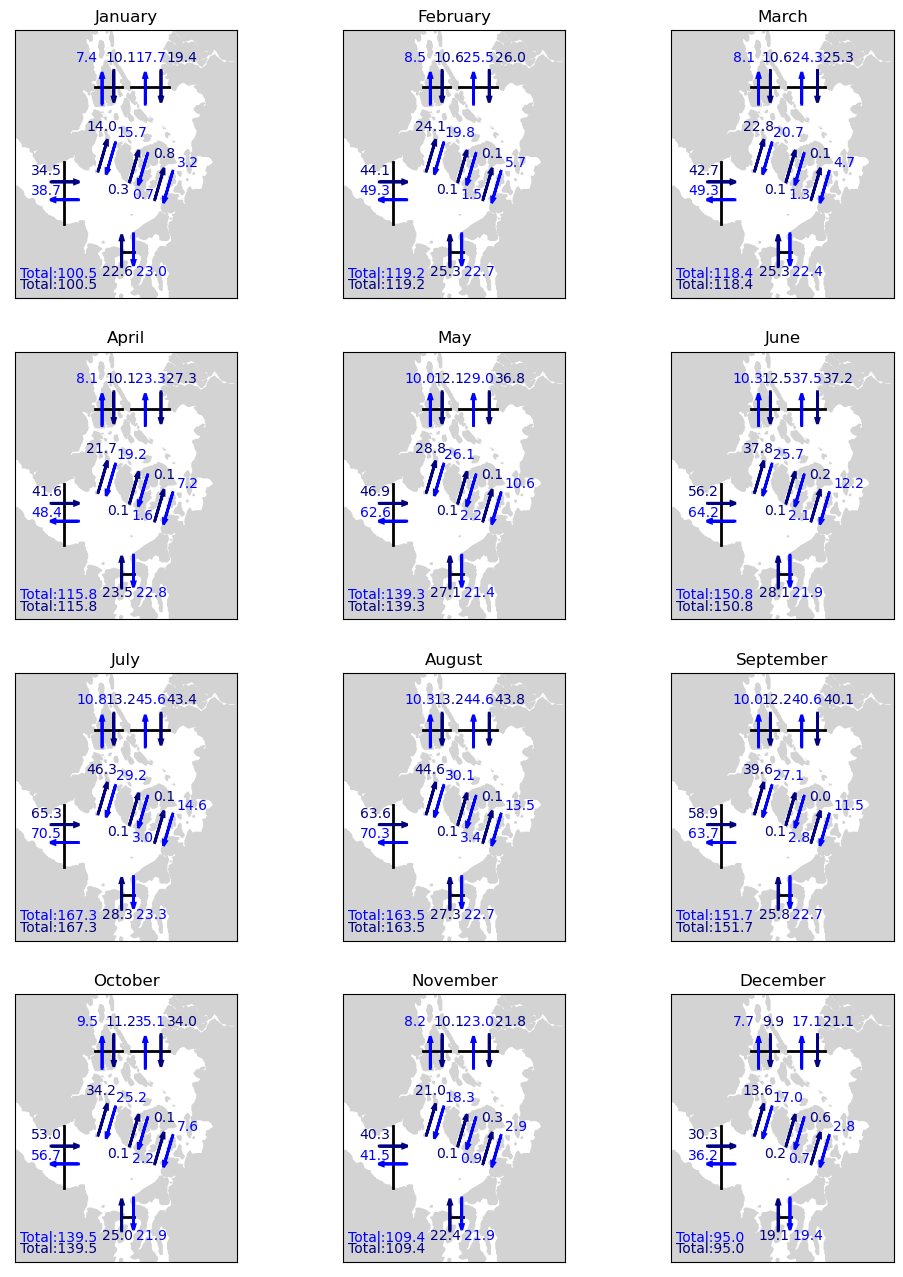

In [16]:
vs_y = np.arange(233,303,1)
vs_x = np.linspace(177,177,len(vs_y))
adm_x = np.arange(252,267,1)
adm_y = np.linspace(201,201,len(adm_x))
pr_x = np.arange(262,311,1)
pr_y = np.linspace(386,386,len(pr_x))
gulf_x = np.arange(216,251,1)
gulf_y = np.linspace(386,386,len(gulf_x))

months = ['January','February','March','April','May','June','July','August','September','October','November','December']
lw = 2

subdomain = [114, 397, 150, 450]
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6],[ax7,ax8,ax9],[ax10,ax11,ax12]] = plt.subplots(4,3,figsize=(12, 16))

for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]):
    for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
        getattr(ax, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

    ax.set_xlim(subdomain[:2])
    ax.set_ylim(subdomain[2:])
    # ax.set_xlabel('Grid X')
    # ax.set_ylabel('Grid Y')
    ax.set_xticks([])
    ax.set_yticks([])
    viz_tools.set_aspect(ax);

    ax.plot(vs_x,vs_y,color='k',lw=2)
    ax.plot(adm_x,adm_y,color='k',lw=2)
    ax.plot(pr_x,pr_y,color='k',lw=2)
    ax.plot(gulf_x,gulf_y,color='k',lw=2)

    #VicSill arrows
    ax.text(135, 288, '{:.1f}'.format(float(np.round(leave_vic_thru[ii] / 1000, 1))),color='navy')
    ax.text(135, 265, '{:.1f}'.format(float(np.round(ent_vic_thru[ii] / 1000, 1))),color='blue')
    ax.arrow(160, 280, 30, 0, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(195, 260, -30, 0, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    #PointRob arrows
    ax.text(267, 415, '{:.1f}'.format(float(np.round(ent_pr_thru[ii] / 1000, 1))),color='blue')
    ax.text(307, 415, '{:.1f}'.format(float(np.round(leave_pr_thru[ii] / 1000, 1))),color='navy')
    ax.arrow(280, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    ax.arrow(300, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

    #Gulf arrows
    ax.text(192, 415, '{:.1f}'.format(float(np.round(ent_gulf_thru[ii] / 1000, 1))),color='blue')
    ax.text(229, 415, '{:.1f}'.format(float(np.round(leave_gulf_thru[ii] / 1000, 1))),color='navy')
    ax.arrow(225, 367, 0, 30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    ax.arrow(240, 405, 0, -30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)

    #Adm arrows
    ax.text(225, 175, '{:.1f}'.format(float(np.round(leave_adm_thru[ii] / 1000, 1))),color='navy')
    ax.text(268, 175, '{:.1f}'.format(float(np.round(ent_adm_thru[ii] / 1000, 1))),color='blue')
    ax.arrow(250, 185, 0, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(265, 222, 0, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    #Haro arrows
    ax.text(205, 337, '{:.1f}'.format(float(np.round(N_haro[ii] / 1000, 1))),color='navy')
    ax.text(243, 330, '{:.1f}'.format(float(np.round(S_haro[ii] / 1000, 1))),color='blue')
    ax.arrow(220, 292, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(242, 324, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    # #SJC arrows
    ax.text(232, 267, '{:.1f}'.format(float(np.round(N_sjc[ii] / 1000, 1))),color='navy')
    ax.text(263, 261, '{:.1f}'.format(float(np.round(S_sjc[ii] / 1000, 1))),color='blue')
    ax.arrow(260, 280, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(283, 312, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)

    # #Rosario arrows
    ax.text(290, 307, '{:.1f}'.format(float(np.round(N_ros[ii] / 1000, 1))),color='navy')
    ax.text(320, 297, '{:.1f}'.format(float(np.round(S_ros[ii] / 1000, 1))),color='blue')
    ax.arrow(292, 260, 10, 30, head_width=4, edgecolor='navy', facecolor='navy', zorder=10,lw=lw)
    ax.arrow(315, 292, -10, -30, head_width=4, edgecolor='blue', facecolor='blue', zorder=10,lw=lw)
    
    #Total
    ax.text(120, 160, 'Total:'+ '{:.1f}'.format(float(np.round(ent_total[ii] / 1000, 1))),color='navy')
    ax.text(120, 173, 'Total:'+ '{:.1f}'.format(float(np.round(leave_total[ii] / 1000, 1))),color='blue')
    
    ax.set_title(months[ii])

# fig.subplots_adjust(hspace=0.08,wspace=-0.35)

### Averages

Averages of scaled vs. original

In [17]:
np.mean(N_haro+N_ros+N_sjc),np.mean(S_haro+S_ros+S_sjc)

(29403.527601241978, 32735.525220436753)

These are to vicsill and admiralty. Look at just to vicsill for better comparison

In [18]:
mean_NS_N,mean_NS_S = np.mean(vstopr_haro_avg_NS+vstopr_ros_avg_NS+vstopr_sjc_avg_NS+vstogulf_haro_avg_NS+vstogulf_ros_avg_NS+vstogulf_sjc_avg_NS),np.mean(prtovs_haro_avg_NS+prtovs_ros_avg_NS+prtovs_sjc_avg_NS+gulftovs_haro_avg_NS+gulftovs_ros_avg_NS+gulftovs_sjc_avg_NS)
print(f'Not scaled: {mean_NS_N} (N), {mean_NS_S} (S)')

Not scaled: Transport    28032.382531
dtype: float64 (N), Transport    30661.832316
dtype: float64 (S)


/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


##### Allen et al. 25.9 mSv (N) and 31.7 mSv (S)

### Averages of north / south through Haro (compare to Khangaonkar)

In [19]:
print('North through Haro:',np.mean(N_haro))
print('South through Haro:',np.mean(S_haro))

North through Haro: 29034.881449751858
South through Haro: 22832.61276169214


##### Khangoakar -> 56.4 (N) and 31.8 (S)

Yearly averaged at Point Roberts Boundary

In [20]:
print('Leaving PR:',np.mean(leave_pr))
print('Entering PR:',np.mean(ent_pr))

Leaving PR: 37503.79172135352
Entering PR: 33216.105449708244


In [21]:
print('Entering adm:',np.mean(ent_adm))
print('Leaving adm:',np.mean(leave_adm))

Entering adm: 25816.329301113186
Leaving adm: 27039.06745809298


Khangaokar: 
- Leaving PR (33.6 mSv)
- Entering PR (27.7 mSv)
- Entering adm (15.5 mSv)
- Leaving adm (15.3 mSv)

### Delta plots

In [22]:
idx_1 = 0
idx_2 = 6

delta_leave_adm = leave_adm - leave_adm_thru
delta_ent_adm = ent_adm - ent_adm_thru
leave_adm_JJ = np.array([leave_adm[idx_1],leave_adm_thru[idx_1],delta_leave_adm[idx_1],leave_adm[idx_2],leave_adm_thru[idx_2],delta_leave_adm[idx_2]])
ent_adm_JJ = np.array([ent_adm[idx_1],ent_adm_thru[idx_1],delta_ent_adm[idx_1],ent_adm[idx_2],ent_adm_thru[idx_2],delta_ent_adm[idx_2]])

delta_leave_pr = leave_pr - leave_pr_thru
delta_ent_pr = ent_pr - ent_pr_thru
leave_pr_JJ = np.array([leave_pr[idx_1],leave_pr_thru[idx_1],delta_leave_pr[idx_1],leave_pr[idx_2],leave_pr_thru[idx_2],delta_leave_pr[idx_2]])
ent_pr_JJ = np.array([ent_pr[idx_1],ent_pr_thru[idx_1],delta_ent_pr[idx_1],ent_pr[idx_2],ent_pr_thru[idx_2],delta_ent_pr[idx_2]])

delta_leave_gulf = leave_gulf - leave_gulf_thru
delta_ent_gulf = ent_gulf - ent_gulf_thru
leave_gulf_JJ = np.array([leave_gulf[idx_1],leave_gulf_thru[idx_1],delta_leave_gulf[idx_1],leave_gulf[idx_2],leave_gulf_thru[idx_2],delta_leave_gulf[idx_2]])
ent_gulf_JJ = np.array([ent_gulf[idx_1],ent_gulf_thru[idx_1],delta_ent_gulf[idx_1],ent_gulf[idx_2],ent_gulf_thru[idx_2],delta_ent_gulf[idx_2]])

delta_leave_vic = leave_vic - leave_vic_thru
delta_ent_vic = ent_vic - ent_vic_thru
leave_vic_JJ = np.array([leave_vic[idx_1],leave_vic_thru[idx_1],delta_leave_vic[idx_1],leave_vic[idx_2],leave_vic_thru[idx_2],delta_leave_vic[idx_2]])
ent_vic_JJ = np.array([ent_vic[idx_1],ent_vic_thru[idx_1],delta_ent_vic[idx_1],ent_vic[idx_2],ent_vic_thru[idx_2],delta_ent_vic[idx_2]])

### Look at whats going through channels in no innner boundaries experiment

In [23]:
Nthru = vstopr + vstogulf + admtopr + admtogulf
Nthru.Transport[6]

49082.92730157478

In [24]:
Nthru_full = N_haro + N_ros + N_sjc

In [25]:
Nthru_full[6]

array([46590.3963632])

Text(0.5, 1.0, 'Difference in northward flow through channels (no inner bnys - full region)')

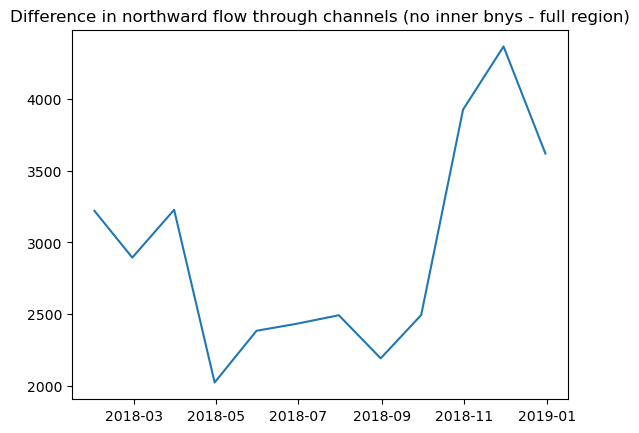

In [26]:
plt.plot(Nthru - Nthru_full)
plt.title('Difference in northward flow through channels (no inner bnys - full region)')

In [27]:
np.mean(Nthru - Nthru_full).values

/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


array([2939.24387219])

In [28]:
np.mean((Nthru-Nthru_full)/Nthru)

/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Transport    0.104585
dtype: float64

In [29]:
Sthru = prtovs + gulftovs + gulftoadm + prtoadm
Sthru.Transport[6]

54516.911992400084

In [30]:
Sthru_full = S_haro + S_ros + S_sjc
Sthru_full[6]

array([46785.03836086])

Text(0.5, 1.0, 'Difference in southward flow through channels (no inner bnys - full region)')

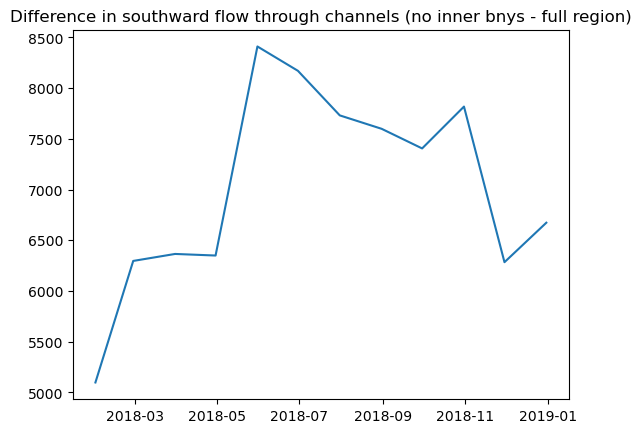

In [31]:
plt.plot(Sthru-Sthru_full)
plt.title('Difference in southward flow through channels (no inner bnys - full region)')

In [32]:
np.mean(Sthru-Sthru_full).values

/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


array([7017.31203411])

In [33]:
(Sthru-Sthru_full)/Sthru

,Transport
2018-01-31,0.206382
2018-02-28,0.189322
2018-03-31,0.192738
2018-04-30,0.184846
2018-05-31,0.177801
2018-06-30,0.169672
2018-07-31,0.141825
2018-08-31,0.139354
2018-09-30,0.151666
2018-10-31,0.182861


In [34]:
np.mean((Sthru-Sthru_full)/Sthru)

/home/cstang/conda_envs/analysis-camryn/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Transport    0.183602
dtype: float64

In [35]:
idx_1 = 0
idx_2 = 6

delta_Sthru = Sthru-Sthru_full
delta_Nthru = Nthru-Nthru_full

delta_leave_adm = leave_adm - leave_adm_thru
delta_ent_adm = ent_adm - ent_adm_thru
Sthru_JJ = np.array([Sthru.iloc[idx_1],Sthru_full[idx_1],delta_Sthru.iloc[idx_1],Sthru.iloc[idx_2],Sthru_full[idx_2],delta_Sthru.iloc[idx_2]])
Nthru_JJ = np.array([Nthru.iloc[idx_1],Nthru_full[idx_1],delta_Nthru.iloc[idx_1],Nthru.iloc[idx_2],Nthru_full[idx_2],delta_Nthru.iloc[idx_2]])

/tmp/ipykernel_2783529/103581906.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(135, 288, '{:.1f}'.format(float(np.round(leave_vic_JJ[ii] / 1000, 1))),color=color1)
/tmp/ipykernel_2783529/103581906.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(135, 265, '{:.1f}'.format(float(np.round(ent_vic_JJ[ii] / 1000, 1))),color=color2)
/tmp/ipykernel_2783529/103581906.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(267, 415, '{:.1f}'.

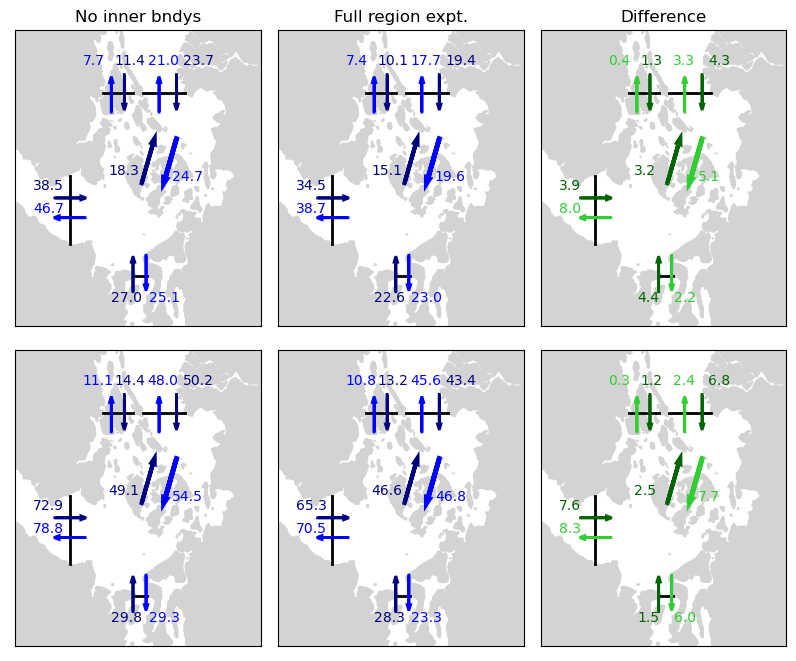

In [36]:
title_name = ['No inner bndys','Full region expt.','Difference']
color1 = 'navy'
color2 = 'blue'

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(12, 8))

for ii,ax in enumerate([ax1,ax2,ax3,ax4,ax5,ax6]):
    
    for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
        getattr(ax, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

    ax.set_xlim(subdomain[:2])
    ax.set_ylim(subdomain[2:])
    ax.set_xticks([])
    ax.set_yticks([])
    viz_tools.set_aspect(ax);

    ax.plot(vs_x,vs_y,color='k',lw=2)
    ax.plot(adm_x,adm_y,color='k',lw=2)
    ax.plot(pr_x,pr_y,color='k',lw=2)
    ax.plot(gulf_x,gulf_y,color='k',lw=2)
    
    if (ii == 2) or (ii == 5):
        color1 = 'darkgreen'
        color2 = 'limegreen'
    else:
        color1 = 'navy'
        color2 = 'blue'

    #VicSill arrows
    ax.text(135, 288, '{:.1f}'.format(float(np.round(leave_vic_JJ[ii] / 1000, 1))),color=color1)
    ax.text(135, 265, '{:.1f}'.format(float(np.round(ent_vic_JJ[ii] / 1000, 1))),color=color2)
    ax.arrow(160, 280, 30, 0, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
    ax.arrow(195, 260, -30, 0, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)

    #PointRob arrows
    ax.text(267, 415, '{:.1f}'.format(float(np.round(ent_pr_JJ[ii] / 1000, 1))),color=color2)
    ax.text(307, 415, '{:.1f}'.format(float(np.round(leave_pr_JJ[ii] / 1000, 1))),color=color1)
    ax.arrow(280, 367, 0, 30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
    ax.arrow(300, 405, 0, -30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)

    #Gulf arrows
    ax.text(192, 415, '{:.1f}'.format(float(np.round(ent_gulf_JJ[ii] / 1000, 1))),color=color2)
    ax.text(229, 415, '{:.1f}'.format(float(np.round(leave_gulf_JJ[ii] / 1000, 1))),color=color1)
    ax.arrow(225, 367, 0, 30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
    ax.arrow(240, 405, 0, -30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)

    #Adm arrows
    ax.text(225, 175, '{:.1f}'.format(float(np.round(leave_adm_JJ[ii] / 1000, 1))),color=color1)
    ax.text(268, 175, '{:.1f}'.format(float(np.round(ent_adm_JJ[ii] / 1000, 1))),color=color2)
    ax.arrow(250, 185, 0, 30, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=lw)
    ax.arrow(265, 222, 0, -30, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=lw)
    
    #Thru transport
    ax.text(222, 303, '{:.1f}'.format(float(np.round(Nthru_JJ[ii] / 1000, 1))),color=color1)
    ax.text(295, 297, '{:.1f}'.format(float(np.round(Sthru_JJ[ii] / 1000, 1))),color=color2)
    ax.arrow(260, 295, 13, 40, head_width=4, edgecolor=color1, facecolor=color1, zorder=10,lw=3)
    ax.arrow(300, 340, -13, -40, head_width=4, edgecolor=color2, facecolor=color2, zorder=10,lw=3.5)
    

ax1.set_title(title_name[0])
ax2.set_title(title_name[1])
ax3.set_title(title_name[2])

fig.subplots_adjust(hspace=0.08,wspace=-0.35)

In [37]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/delta_balance.png',bbox_inches='tight')

Note that the arrows going through the SJGI region include all the flow going through Haro Strait, Rosario Strait, and San Juan Channel.